# 02. Neuralnet Q Learning example

Neuralnet Q Learning을 실습해본다. 신경망의 parameter(weight)를 업데이트 함에 따라 state에 대한 Q value가 변화한다. Q Learning의 TD error를 loss function으로 하여 학습한다.

In [1]:
import tensorflow as tf
import numpy as np
import random
import gym

import matplotlib.pyplot as plt
%matplotlib inline

np.random.seed(285)
tf.set_random_seed(285)

print("tensorflow version: ", tf.__version__)
print("gym version: ", gym.__version__)

/home/khkim/anaconda3/envs/sonic/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


tensorflow version:  1.7.0
gym version:  0.10.5


## Frozen Lake

**[state]**

        SFFF
        FHFH
        FFFH
        HFFG

    S : starting point, safe
    F : frozen surface, safe
    H : hole, fall to your doom
    G : goal, where the frisbee is located
    
**[action]**

    LEFT = 0
    DOWN = 1
    RIGHT = 2
    UP = 3

### Frozen Lake (not Slippery)

In [2]:
def register_frozen_lake_not_slippery(name):
    from gym.envs.registration import register
    register(
        id=name,
        entry_point='gym.envs.toy_text:FrozenLakeEnv',
        kwargs={'map_name' : '4x4', 'is_slippery': False},
        max_episode_steps=100,
        reward_threshold=0.78, # optimum = .8196
    )

register_frozen_lake_not_slippery('FrozenLakeNotSlippery-v0')

## Q-Learning using Neural Network  
**Update 식**  
  
$J(w) = \mathbb{E}_{\pi}[(target - \hat q(S,A,w))^2]$  
  
$ \begin{align} \Delta w & = - \frac{1}{2} \alpha \nabla_w J(w)
\\ & = \alpha (R_{t+1} + \gamma max(\hat q(S_{t+1},a ,w)) - \hat q(S_{t},A_{t},w))\nabla_w \hat q(S_{t},A_{t},w) \end{align}$


In [3]:
# Load Environment
env = gym.make('FrozenLakeNotSlippery-v0')
state_size = env.observation_space.n
action_size = env.action_space.n
print(state_size)
print(action_size)

16
4


### Build graph

In [4]:
layers = tf.contrib.layers

inputs = tf.placeholder(shape=[1], dtype=tf.int64, name="state")
input_action = tf.placeholder(shape=[1], dtype=tf.int64, name="action")
target = tf.placeholder(shape=[1], dtype=tf.float32, name="targetQ")

def build_network(inputs):   
    with tf.variable_scope('q_net'):
        input_onehot = tf.one_hot(inputs, state_size, dtype=tf.float32)
        fc1 = layers.fully_connected(inputs=input_onehot,
                                                  num_outputs=4,
                                                  activation_fn=None)
    return fc1

q_value = build_network(inputs)

curr_action = tf.one_hot(input_action, action_size)
curr_q_value = tf.reduce_sum(tf.multiply(q_value, curr_action))

loss_op = tf.square(target - curr_q_value)
opt = tf.train.GradientDescentOptimizer(learning_rate=0.1)
train_op = opt.minimize(loss_op)

Instructions for updating:
Use the retry module or similar alternatives.


### Executing a graph in a tf.Session

In [5]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

for var in tf.trainable_variables('q_net'):
    print(var)
    print(sess.run(var))

<tf.Variable 'q_net/fully_connected/weights:0' shape=(16, 4) dtype=float32_ref>
[[ 0.2162689  -0.04209244 -0.18740913  0.40012634]
 [ 0.06300414 -0.23828828 -0.4625148  -0.30623412]
 [ 0.31529337  0.07133931 -0.06658944 -0.40562344]
 [-0.18270525 -0.5041441  -0.54295003  0.2640555 ]
 [ 0.48183274  0.09367412 -0.5418519  -0.2928808 ]
 [-0.508601    0.29297888  0.03464401  0.24687386]
 [ 0.08938801  0.39754945 -0.45648232 -0.21298245]
 [-0.30371952 -0.54674184  0.22959405 -0.19876277]
 [-0.5302222  -0.070921    0.34657186  0.35331672]
 [ 0.4634298   0.26453108  0.41928977  0.40222108]
 [ 0.5036266   0.5022012  -0.12703645 -0.3552447 ]
 [ 0.315975    0.3467458  -0.39459467 -0.41172564]
 [ 0.42311925  0.44070476  0.4625318   0.22824848]
 [-0.03177029  0.05783397 -0.5104612   0.30487603]
 [ 0.00325227  0.54530466  0.34945917 -0.03912801]
 [ 0.5154786   0.39003116 -0.4095614   0.4295683 ]]
<tf.Variable 'q_net/fully_connected/biases:0' shape=(4,) dtype=float32_ref>
[0. 0. 0. 0.]


### Action select using Q value

In [6]:
state = env.reset()
state = np.reshape(state, [1])
print(state)

curr_q = sess.run(q_value, feed_dict={inputs: state})
print(curr_q)
print(np.flatnonzero(curr_q[state] == curr_q[state]))
action = np.random.choice(np.flatnonzero(curr_q[state] == curr_q[state]).max())
print(action)

[0]
[[ 0.2162689  -0.04209244 -0.18740913  0.40012634]]
[0 1 2 3]
1


In [7]:
next_state, reward, done, _ = env.step(action)
next_state = np.reshape(next_state, [1])
print(next_state)

gamma = 0.9
if done:
    next_q_value = np.array([reward])
else:
    next_q_value = reward + gamma * sess.run(q_value, feed_dict={inputs: next_state})[:, action]
print(next_q_value)

[4]
[0.08430671]


### Update Neural Net

In [8]:
action = np.reshape(action, [1])
loss, _ = sess.run([loss_op, train_op], feed_dict={inputs: state, target: next_q_value, input_action: action})
print(loss)

for var in tf.trainable_variables('q_net'):
    print(var)
    print(sess.run(var))

[0.01597675]
<tf.Variable 'q_net/fully_connected/weights:0' shape=(16, 4) dtype=float32_ref>
[[ 0.2162689  -0.01681261 -0.18740913  0.40012634]
 [ 0.06300414 -0.23828828 -0.4625148  -0.30623412]
 [ 0.31529337  0.07133931 -0.06658944 -0.40562344]
 [-0.18270525 -0.5041441  -0.54295003  0.2640555 ]
 [ 0.48183274  0.09367412 -0.5418519  -0.2928808 ]
 [-0.508601    0.29297888  0.03464401  0.24687386]
 [ 0.08938801  0.39754945 -0.45648232 -0.21298245]
 [-0.30371952 -0.54674184  0.22959405 -0.19876277]
 [-0.5302222  -0.070921    0.34657186  0.35331672]
 [ 0.4634298   0.26453108  0.41928977  0.40222108]
 [ 0.5036266   0.5022012  -0.12703645 -0.3552447 ]
 [ 0.315975    0.3467458  -0.39459467 -0.41172564]
 [ 0.42311925  0.44070476  0.4625318   0.22824848]
 [-0.03177029  0.05783397 -0.5104612   0.30487603]
 [ 0.00325227  0.54530466  0.34945917 -0.03912801]
 [ 0.5154786   0.39003116 -0.4095614   0.4295683 ]]
<tf.Variable 'q_net/fully_connected/biases:0' shape=(4,) dtype=float32_ref>
[0.         0.

In [9]:
rlist = []
slist = []
epsilon_list = []

EPISODE = 2000
gamma = 0.99

update_count = 0
loss_list = []

# Episode 수만큼 반복
for step in range(EPISODE):
    epsilon = 1. / ((step/50)+10)
    epsilon_list.append(epsilon)
    
    state = env.reset()
    state = np.reshape(state, [1])
    print("[Episode {}]".format(step))
    total_reward = 0
    limit = 0
    done = False
    
    while not done and limit < 99:
        # select action by e-greedy policy
        curr_q = sess.run(q_value, feed_dict={inputs: state})
        
        if epsilon > np.random.rand(1):
            action = env.action_space.sample()
        else:
            action = np.argmax(curr_q)   
            
        # do action and go to next state
        next_state, reward, done, _ = env.step(action)
        next_state = np.reshape(next_state, [1])
                          
        if reward == 1.0:
            print("GOAL")
        
        # episode가 끝났다면
        if done:
            next_q_value = np.array([reward])
        # 끝나지 않았다면
        else:
            next_q_value = reward + gamma * np.max(sess.run(q_value, feed_dict={inputs: next_state}), axis=1)
        
        # Q update
        action = np.reshape(action, [1])
        loss, _ = sess.run([loss_op, train_op], feed_dict={inputs: state, target: next_q_value, input_action: action})
        loss_list.append(loss)
        update_count += 1
        
        slist.append(state.item())
        state = next_state
        total_reward += reward
        limit += 1
        
    print(slist)
    slist = []
    print("total reward: ", total_reward)
    rlist.append(total_reward)
    
print("성공한 확률" + str(sum(rlist) / EPISODE) + "%")

[Episode 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
total reward:  0.0
[Episode 1]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4]
total reward:  0.0
[Episode 2]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]
total reward:  0.0
[Episode 3]
[0, 4]
total reward:  0.0
[Episode 4]
[0, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 0, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 0, 0, 4]
total reward:  0.0
[Episode 5]
[0, 0, 0,

[0, 4, 8, 4, 8, 9]
total reward:  0.0
[Episode 97]
GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 98]
GOAL
[0, 4, 8, 9, 10, 14, 10, 14]
total reward:  1.0
[Episode 99]
GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 100]
GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 101]
GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 102]
[0, 4, 8]
total reward:  0.0
[Episode 103]
GOAL
[0, 0, 0, 4, 4, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 104]
GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 105]
GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 106]
GOAL
[0, 4, 8, 9, 10, 9, 10, 14]
total reward:  1.0
[Episode 107]
GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 108]
GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 109]
GOAL
[0, 4, 8, 9, 10, 14, 14]
total reward:  1.0
[Episode 110]
GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 111]
GOAL
[0, 4, 8, 9, 13, 9, 10, 6, 10, 14]
total reward:  1.0
[Episode 112]
GOAL
[0, 4, 8, 9, 8, 9, 10, 14]
total

GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 236]
GOAL
[0, 4, 8, 9, 10, 14, 10, 14]
total reward:  1.0
[Episode 237]
GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 238]
[0, 4, 8, 9, 13]
total reward:  0.0
[Episode 239]
GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 240]
GOAL
[0, 4, 8, 8, 9, 10, 14]
total reward:  1.0
[Episode 241]
GOAL
[0, 4, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 242]
GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 243]
GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 244]
GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 245]
GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 246]
GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 247]
GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 248]
GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 249]
[0, 4, 8, 9]
total reward:  0.0
[Episode 250]
GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 251]
GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 252]
GOAL


GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 386]
GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 387]
GOAL
[0, 0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 388]
GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 389]
GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 390]
GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 391]
GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 392]
GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 393]
GOAL
[0, 4, 8, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 394]
GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 395]
GOAL
[0, 4, 8, 9, 10, 14, 13, 9, 8, 9, 10, 14]
total reward:  1.0
[Episode 396]
[0, 4, 4, 8, 9, 10]
total reward:  0.0
[Episode 397]
GOAL
[0, 4, 0, 4, 8, 4, 4, 8, 4, 4, 8, 4, 4, 8, 4, 4, 8, 4, 4, 8, 4, 4, 8, 4, 4, 8, 4, 4, 8, 8, 4, 4, 8, 4, 4, 8, 8, 4, 8, 8, 9, 13, 9, 13, 9, 13, 9, 8, 9, 13, 9, 13, 9, 13, 9, 8, 9, 13, 9, 10, 14, 10, 14]
total reward:  1.0
[Episode 398]
GOAL
[0, 4, 4, 4, 4, 8, 9, 10

GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 528]
GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 529]
GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 530]
GOAL
[0, 4, 8, 9, 10, 14, 14]
total reward:  1.0
[Episode 531]
GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 532]
GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 533]
GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 534]
GOAL
[0, 4, 0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 535]
GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 536]
GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 537]
GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 538]
GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 539]
[0, 0, 4]
total reward:  0.0
[Episode 540]
GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 541]
GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 542]
GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 543]
GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 544]
[0,

GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 667]
GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 668]
GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 669]
GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 670]
GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 671]
GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 672]
GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 673]
GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 674]
GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 675]
GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 676]
GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 677]
GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 678]
GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 679]
GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 680]
[0, 4, 4, 8, 9, 10]
total reward:  0.0
[Episode 681]
GOAL
[0, 4, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 682]
GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 683]


GOAL
[0, 4, 8, 9, 10, 14, 10, 14]
total reward:  1.0
[Episode 804]
GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 805]
GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 806]
GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 807]
GOAL
[0, 4, 8, 9, 10, 6, 10, 14]
total reward:  1.0
[Episode 808]
GOAL
[0, 4, 8, 9, 13, 9, 10, 14]
total reward:  1.0
[Episode 809]
GOAL
[0, 0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 810]
GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 811]
GOAL
[0, 4, 0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 812]
[0, 4, 8, 9]
total reward:  0.0
[Episode 813]
GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 814]
GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 815]
GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 816]
GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 817]
GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 818]
GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 819]
[0, 4, 8, 9, 10]
total reward:  0.0
[E

GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 960]
GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 961]
GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 962]
GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 963]
GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 964]
[0, 4, 8, 9, 10]
total reward:  0.0
[Episode 965]
GOAL
[0, 4, 8, 9, 8, 9, 10, 14]
total reward:  1.0
[Episode 966]
GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 967]
GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 968]
GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 969]
GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 970]
GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 971]
GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 972]
GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 973]
GOAL
[0, 4, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 974]
GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 975]
GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 97

GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 1116]
GOAL
[0, 4, 8, 9, 10, 9, 10, 14]
total reward:  1.0
[Episode 1117]
GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 1118]
GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 1119]
GOAL
[0, 1, 0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 1120]
GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 1121]
GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 1122]
GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 1123]
GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 1124]
GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 1125]
GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 1126]
GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 1127]
GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 1128]
GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 1129]
GOAL
[0, 4, 8, 9, 10, 9, 10, 14]
total reward:  1.0
[Episode 1130]
GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 1131]
[0, 4]
total reward:

GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 1255]
GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 1256]
GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 1257]
GOAL
[0, 4, 8, 9, 10, 6, 10, 14]
total reward:  1.0
[Episode 1258]
GOAL
[0, 4, 8, 9, 13, 9, 10, 14]
total reward:  1.0
[Episode 1259]
GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 1260]
GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 1261]
GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 1262]
GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 1263]
GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 1264]
GOAL
[0, 1, 0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 1265]
GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 1266]
GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 1267]
GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 1268]
GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 1269]
GOAL
[0, 1, 0, 4, 8, 9, 10, 14, 10, 14]
total reward:  1.0
[Episode 1270]
GOAL
[

GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 1420]
GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 1421]
GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 1422]
GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 1423]
GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 1424]
GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 1425]
GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 1426]
GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 1427]
GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 1428]
GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 1429]
GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 1430]
GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 1431]
GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 1432]
GOAL
[0, 1, 0, 1, 0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 1433]
GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 1434]
GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 1435]
GOAL
[0, 4, 8, 9, 10, 14]
to

[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 1567]
GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 1568]
GOAL
[0, 0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 1569]
GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 1570]
GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 1571]
GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 1572]
GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 1573]
GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 1574]
GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 1575]
GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 1576]
GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 1577]
GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 1578]
GOAL
[0, 0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 1579]
GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 1580]
GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 1581]
GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 1582]
GOAL
[0, 4, 8, 9, 10, 14]
total reward:

GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 1713]
GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 1714]
GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 1715]
GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 1716]
GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 1717]
GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 1718]
GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 1719]
GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 1720]
GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 1721]
GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 1722]
GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 1723]
GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 1724]
GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 1725]
GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 1726]
GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 1727]
GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 1728]
GOAL
[0, 4, 8, 9, 10, 14]
total reward: 

GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 1857]
GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 1858]
GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 1859]
GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 1860]
GOAL
[0, 0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 1861]
GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 1862]
GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 1863]
GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 1864]
GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 1865]
GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 1866]
GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 1867]
GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 1868]
GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 1869]
GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 1870]
GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 1871]
GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 1872]
GOAL
[0, 4, 8, 9, 10, 14]
total rewar

GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 1995]
GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 1996]
GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 1997]
GOAL
[0, 4, 8, 9, 10, 14, 14]
total reward:  1.0
[Episode 1998]
GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 1999]
GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
성공한 확률0.953%


In [10]:
for var in tf.trainable_variables('q_net'):
    print(var)
    print(sess.run(var))

<tf.Variable 'q_net/fully_connected/weights:0' shape=(16, 4) dtype=float32_ref>
[[ 0.272746    0.4327445   0.39156675  0.29019085]
 [ 0.27432075 -0.23828828 -0.29920202 -0.22493915]
 [ 0.30181816  0.07133931 -0.06658944 -0.40562344]
 [-0.18270525 -0.5041441  -0.54295003  0.2640555 ]
 [ 0.2825833   0.44229162 -0.54361844  0.29289696]
 [-0.508601    0.29297888  0.03464401  0.24687386]
 [ 0.08938801  0.46071622 -0.45648232 -0.10328934]
 [-0.30371952 -0.54674184  0.22959405 -0.19876277]
 [ 0.29114157 -0.51188385  0.42719322  0.30678937]
 [ 0.29189077  0.44221985  0.43702585 -0.63902354]
 [ 0.30498594  0.4717066  -0.5302008   0.32166862]
 [ 0.315975    0.3467458  -0.39459467 -0.41172564]
 [ 0.42311925  0.44070476  0.4625318   0.22824848]
 [-0.15907149  0.05783397 -0.5104612   0.32302913]
 [ 0.29293755  0.47081074  0.4568804   0.33431816]
 [ 0.5154786   0.39003116 -0.4095614   0.4295683 ]]
<tf.Variable 'q_net/fully_connected/biases:0' shape=(4,) dtype=float32_ref>
[0.6686377  0.5183596  0.54

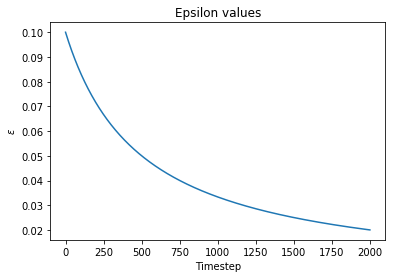

In [11]:
# epsilon 변화 그래프
steps = np.arange(EPISODE)
plt.title('Epsilon values')
plt.xlabel('Timestep')
plt.ylabel('$\\epsilon$')
plt.plot(steps, epsilon_list)

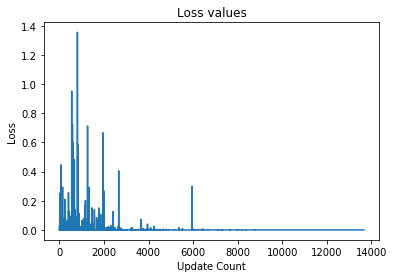

In [12]:
# loss 변화 그래프
update_count = np.arange(update_count)
plt.title('Loss values')
plt.xlabel('Update Count')
plt.ylabel('Loss')
plt.plot(update_count, loss_list)

### Test agent

In [13]:
state = env.reset()
state = np.reshape(state, [1])
done = False
limit = 0

epsilon = 0.0
while not done and limit < 30:
    curr_q = sess.run(q_value, feed_dict={inputs: state})
    action = np.argmax(curr_q)
    next_state, reward, done, _ = env.step(action)
    next_state = np.reshape(next_state, [1])
    env.render()
    state = next_state
    limit += 1

  (Down)
SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Right)
SFFF
FHFH
FFFH
HFFG
  (Right)
SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Right)
SFFF
FHFH
FFFH
HFFG
